### Model

In [3]:
import libs.forward_model as fm
import libs.read_data as rd
import torch

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Parameter Definition
NA = 1.2
Rindex= 1.5
lambda_= 532.0/ 1000 #um
dx, dy, dz= 1/3,1/3,1. #um
ep_dx, ep_dy =2,2
Nx,Ny,Nz = 30,30,21
m = 21
down_factor = .5


fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz,dx,dy,dz)
fm.init_one_shot(m, down_factor=down_factor,num_planes=1)

def one_shot_model(X):
    return torch.matmul(fm.A,X)

print(f"Shape of matrix A: {fm.A.shape}")

Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!
Matrix A is intialized sucessfully...!!!
Shape of matrix A: torch.Size([4725, 18900])


## Reconstruction
$$y=A\cdot x\implies b = (A^{\tiny T}\cdot A)\cdot x\qquad where\quad b = A^{\tiny T}\cdot y$$
***Basic Solution***

$$Y = A\cdot X \implies A^{\tiny T}\cdot Y  = (A^{\tiny T}\cdot A)\cdot X\implies X = (A^{\tiny T}\cdot A)^{-1}\cdot A^{\tiny T}\cdot Y$$

***Gradient Descent Based***

$$x_0\xrightarrow{\texttt{Loss Calculation}}L =\| Ax_0 - b\|\xrightarrow{\texttt{Gradient Descent}}x_1\dots \to L=0$$ 
<!-- ------- -->

In [5]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.67 GiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 5.66 GiB is allocated by PyTorch, and 19.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

***Results***

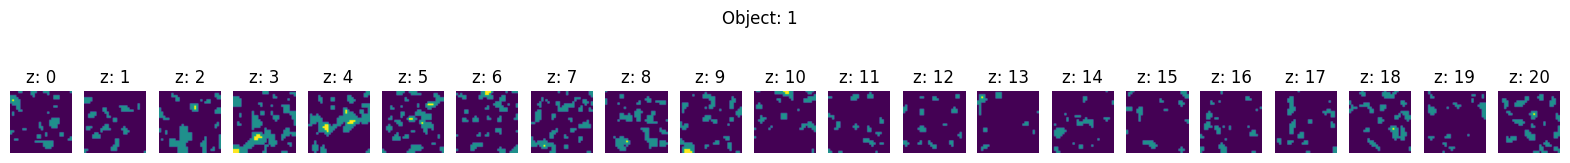

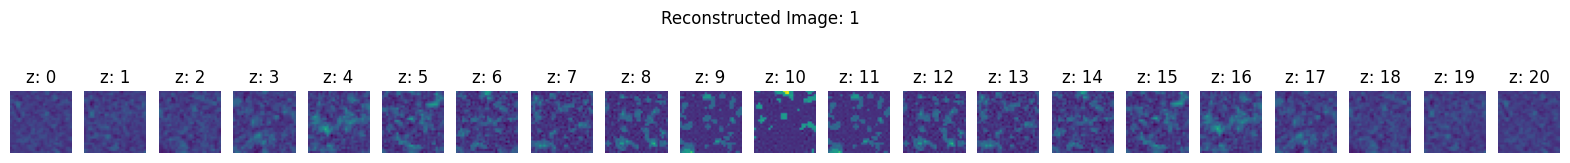

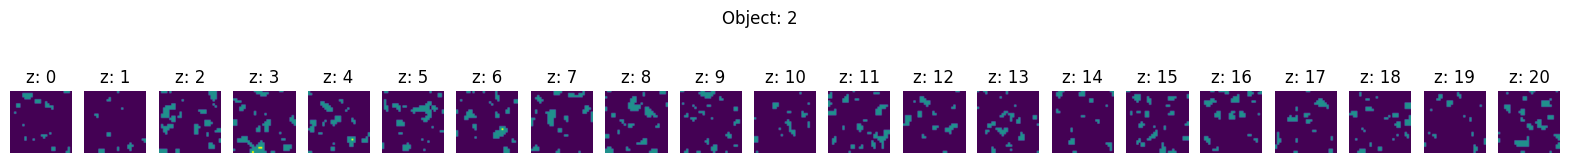

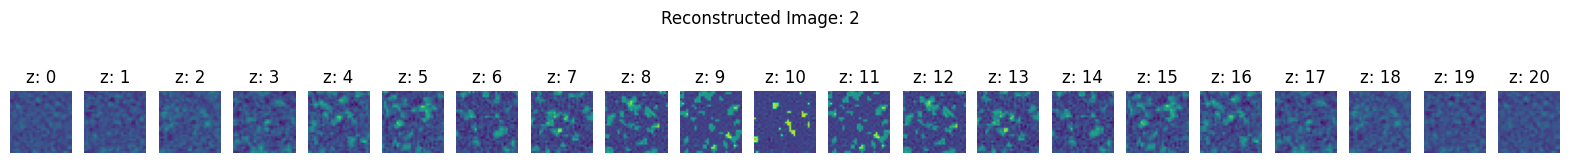

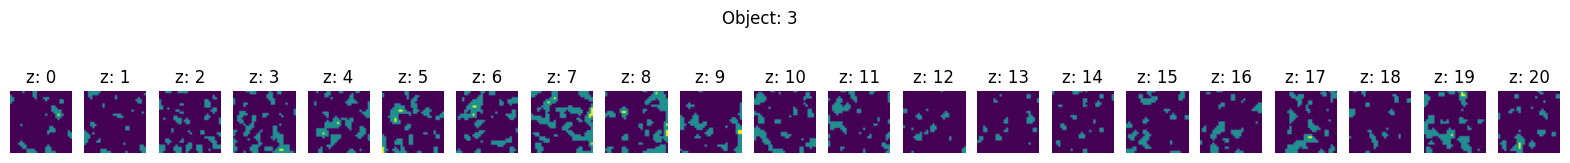

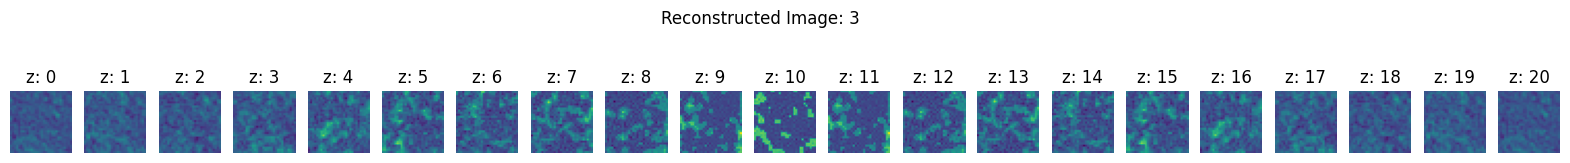

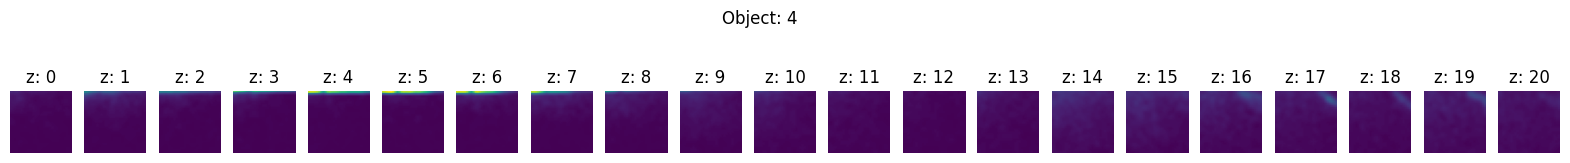

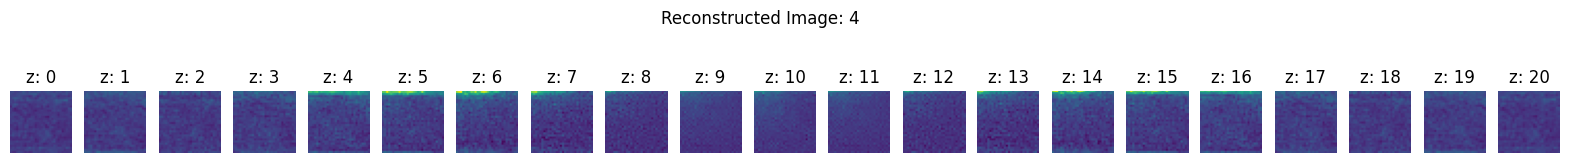

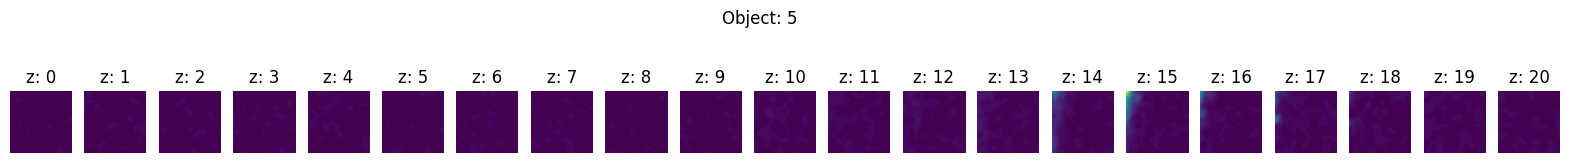

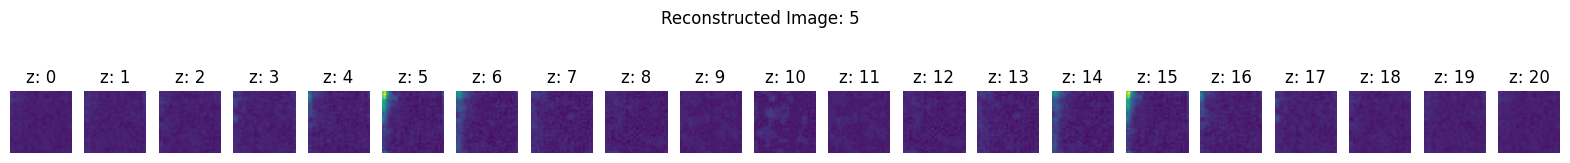

In [6]:
for c_ in range(5):
    rd.load_object("neural_cell", verbose=False)
    X_original = (rd.X).flatten()
    Y = one_shot_model(X_original)
    # X_reconstructed = reconstruct_image_gd(Y)    
    X_reconstructed = torch.linalg.lstsq(fm.A,Y).solution   
    X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
    X3D_orig = X_original.view(Nz,Nx,Ny)
    fm.show_planes_z(X3D_orig.detach().cpu().numpy(),f"Object: {c_+1}",[i for i in range(Nz)])
    fm.show_planes_z(X3D_recons.detach().cpu().numpy(),f"Reconstructed Image: {c_+1}",[i for i in range(Nz)])